# G2M Strategy - Model Development

**Prediction**

Given the results from our cleaned dataset, we have a good understanding of the data and the relationships that exist, and the insights gather will assist in determining the type of model in predicting future `profit`.

Analysis will consist of traditional hypothesis testing to more advanced modeling and techniques.


Time period of data is from **31/01/2016 to 31/12/2018**:


**Resources:**<br>
[G2M Strategy](https://blog.hubspot.com/sales/gtm-strategy)

As a company owner - Using the G2M strategy the focus will be considereably to that of its Customers/Users. Th

1) Can we tell how much would be earned by quarter, period, year of a specific time period? (Predictive analysis, Time Series)

2) What areas (city) generate greatest profit? (Using population and number of users as a reference)

3) Customer preference over pink and yellow?

4) Average age of user? (if applicable create age bins)

5) Average income of user? (hist, highest income user - states)

6) If company purchases a specific fleet of vehicles what is the time range for ROI? (Apply hypothesis testing and A/B Testing)

7) What are users/consumers using more (cash or card)? Are prices equivalent - Upcharge if cash, card transaction is pre-pickup - lower rate?

In [1]:
# Import libraries 
import os
import sys
import pandas as pd
import numpy as np


# Matplotlib Visualizations
import shap
%matplotlib inline
import seaborn as sns
import matplotlib
import eli5
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('fivethirtyeight')
from eli5.sklearn import PermutationImportance


# Plotly visualizations
import plotly
import plotly.express as px
from IPython.display import HTML
import plotly.graph_objects as go
import plotly.express as px
from pylab import rcParams
from plotly import tools
import plotly.graph_objs as go
import plotly.figure_factory as ff
from plotly.offline import init_notebook_mode, iplot
init_notebook_mode(connected=True)


# Sklearn
from sklearn.metrics import r2_score
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import mean_squared_error


# Tensorflow and keras
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import models


# Model Creation
from xgboost import XGBRegressor
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.inspection import permutation_importance
from sklearn.linear_model import Ridge, LinearRegression
from category_encoders import OneHotEncoder, OrdinalEncoder
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, RandomizedSearchCV
from sklearn.model_selection import train_test_split, cross_val_score, validation_curve, GridSearchCV
from sklearn.metrics import roc_curve, plot_roc_curve, mean_absolute_error, mean_squared_error, accuracy_score
pd.set_option('display.max_columns',50)

# Warnings Ignore
import warnings
warnings.filterwarnings("ignore")

# Function to display plotly in jupyter notebook
def enable_plotly_in_cell():
    import IPython
    from plotly.offline import init_notebook_mode
    display(IPython.core.display.HTML('''<script src="/static/components/requirejs/require.js"></script>'''))
    init_notebook_mode(connected=False)
    
print('Matplotlib:',matplotlib.__version__)
print('Pandas:',pd.__version__)
print('Numpy:',np.__version__)
print('Seaborn:',sns.__version__)
print('Plotly:',plotly.__version__)
print('TensorFlow:',tf.__version__)

Matplotlib: 3.1.1
Pandas: 1.1.3
Numpy: 1.23.0
Seaborn: 0.11.2
Plotly: 4.12.0
TensorFlow: 2.7.0


In [2]:
cab_data = pd.read_csv('/Users/jasonrobinson/Desktop/VC/notebooks/cab_data_cleaned')
cab_yellow = pd.read_csv('/Users/jasonrobinson/Desktop/VC/notebooks/yellow_cab.csv')
cab_pink = pd.read_csv('/Users/jasonrobinson/Desktop/VC/notebooks/pink_cab.csv')

### Build on creating statistical analysis - answer business questions.

Perform analysis and provide visualizations to gather further insights and recommendations for the next steps in the process of determing optimal investment following the G2M strategy.

To achieve this we will apply machine learning techniques to predict future profit.

We wil also use the data to determine the optimal investment strategy, related to time series analysis. 
        

In [ ]:
# Wrangle function to clean data
#def wrangle(filepath):
#    # Set conditional satements for filtering times of month to season value
#    condition_winter = (cab_data.index>=1)&(cab_data.index<=3)
#    condtion_spring = (cab_data.index>=4)&(cab_data.index<=6)
#    condition_summer = (cab_data.index>=7)&(cab_data.index<=9)
#    condition_autumn = (cab_data.index>=10)@(cab_data.index<=12)
#    
#    # Create column in dataframe that inputs the season based on the conditions created above
#    cab_data['season'] = np.where(condition_winter,'winter',
#                            np.where(condtion_spring,'spring',
#                                     np.where(condition_summer,'summer',
#                                              np.where(condition_autumn,'autumn',np.nan))))
#
#    return cab_data
#
## Applying the wrangle function to the dataset
#cab_data=wrangle('/Users/jasonrobinson/Desktop/VC/notebooks/cab_data_cleaned')

In [3]:
cab_data = cab_data.drop(['travel_date.1', 'customer_id'], axis=1)

In [4]:
cab_data['travel_date'] = pd.to_datetime(cab_data['travel_date'])
cab_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 344953 entries, 0 to 344952
Data columns (total 14 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   travel_date        344953 non-null  datetime64[ns]
 1   transact_id        344953 non-null  int64         
 2   company            344953 non-null  object        
 3   city               344953 non-null  object        
 4   km_travelled       344953 non-null  float64       
 5   price_charged      344953 non-null  float64       
 6   trip_cost          344953 non-null  float64       
 7   payment_mode       344953 non-null  object        
 8   gender             344953 non-null  object        
 9   age                344953 non-null  int64         
 10  monthly_income     344953 non-null  int64         
 11  price_inc_05       344953 non-null  float64       
 12  price_diff         344953 non-null  float64       
 13  new_price_charged  344953 non-null  float64 

In [5]:
# Create a price increase for price_charged by .5%
cab_data['price_inc_05'] = cab_data['price_charged'] * 1.05

# Create a price increase for price_charged by .10%
cab_data['price_inc_10'] = cab_data['price_charged'] * 1.10

# Difference of price charged and trip cost to get profit
cab_data['profit'] = cab_data['price_charged'] - cab_data['trip_cost']
cab_data.head()

,travel_date,transact_id,company,city,km_travelled,price_charged,trip_cost,payment_mode,gender,age,monthly_income,price_inc_05,price_diff,new_price_charged,price_inc_10,profit
0,2016-02-06,10000011,Pink Cab,ATLANTA GA,30.45,370.95,313.6350,Card,Male,28,10813,389.4975,18.5475,389.4975,408.045,57.3150
1,2018-08-19,10351127,Yellow Cab,ATLANTA GA,26.19,598.70,317.4228,Cash,Male,28,10813,628.6350,29.9350,628.6350,658.570,281.2772
2,2018-12-22,10412921,Yellow Cab,ATLANTA GA,42.55,792.05,597.4020,Card,Male,28,10813,831.6525,39.6025,831.6525,871.255,194.6480
3,2016-02-04,10000012,Pink Cab,ATLANTA GA,28.62,358.52,334.8540,Card,Male,27,9237,376.4460,17.9260,376.4460,394.372,23.6660
4,2018-05-20,10320494,Yellow Cab,ATLANTA GA,36.38,721.10,467.1192,Card,Male,27,9237,757.1550,36.0550,757.1550,793.210,253.9808


In [6]:
# Get dummie data for categoriacal values
#cab_data[['female', 'male']] = pd.get_dummies(cab_data["gender"])
#cab_data[['yellow_cab', 'pink cab']] = pd.get_dummies(cab_data["company"])
#cab_data[['card', 'cash']] = pd.get_dummies(cab_data["payment_mode"])
#cab_data = cab_data.drop(['gender', 'company', 'payment_mode', 'customer_id'], axis=1)

In [7]:
cab_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 344953 entries, 0 to 344952
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   travel_date        344953 non-null  datetime64[ns]
 1   transact_id        344953 non-null  int64         
 2   company            344953 non-null  object        
 3   city               344953 non-null  object        
 4   km_travelled       344953 non-null  float64       
 5   price_charged      344953 non-null  float64       
 6   trip_cost          344953 non-null  float64       
 7   payment_mode       344953 non-null  object        
 8   gender             344953 non-null  object        
 9   age                344953 non-null  int64         
 10  monthly_income     344953 non-null  int64         
 11  price_inc_05       344953 non-null  float64       
 12  price_diff         344953 non-null  float64       
 13  new_price_charged  344953 non-null  float64 

In [8]:
# Daily total price charged
#cab_data['total_price_charged'] = cab_data.groupby('price_diff')['price_charged'].transform('sum')
#cab_data.head()

In [9]:
# Figure showing Price per total load
#fig = px.scatter(cab_data,x='total_price_charged',
#                 y='price_charged',
#                 facet_col='season',
#                 opacity=0.1,
#                 title='Price charged Per Season',
#                 animation_frame=cab_data.index)
#
## Figure customizations
#fig.update_traces(marker=dict(size=12,
#                              line=dict(width=2,
#                                        color='darkslateblue')),
#                  selector=dict(mode='markers'))

In [10]:
cab_data['monthly_income'].sort_values(ascending=False)[:3]

307038    35000
63653     34996
63659     34996
Name: monthly_income, dtype: int64

In [11]:
cab_data.sort_index(ascending=False)

,travel_date,transact_id,company,city,km_travelled,price_charged,trip_cost,payment_mode,gender,age,monthly_income,price_inc_05,price_diff,new_price_charged,price_inc_10,profit
344952,2018-02-02,10439846,Yellow Cab,TUCSON AZ,13.30,244.65,180.3480,Card,Female,32,10128,256.8825,12.2325,256.8825,269.115,64.3020
344951,2018-02-04,10439840,Yellow Cab,TUCSON AZ,5.60,92.42,70.5600,Cash,Male,23,19454,97.0410,4.6210,97.0410,101.662,21.8600
344950,2018-02-02,10439838,Yellow Cab,TUCSON AZ,19.00,303.77,232.5600,Card,Male,38,3960,318.9585,15.1885,318.9585,334.147,71.2100
344949,2018-02-01,10439799,Yellow Cab,SILICON VALLEY,13.72,277.97,172.8720,Cash,Male,33,18713,291.8685,13.8985,291.8685,305.767,105.0980
344948,2018-02-05,10439790,Yellow Cab,SEATTLE WA,16.66,261.18,213.9144,Card,Female,42,19417,274.2390,13.0590,274.2390,287.298,47.2656
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4,2018-05-20,10320494,Yellow Cab,ATLANTA GA,36.38,721.10,467.1192,Card,Male,27,9237,757.1550,36.0550,757.1550,793.210,253.9808
3,2016-02-04,10000012,Pink Cab,ATLANTA GA,28.62,358.52,334.8540,Card,Male,27,9237,376.4460,17.9260,376.4460,394.372,23.6660
2,2018-12-22,10412921,Yellow Cab,ATLANTA GA,42.55,792.05,597.4020,Card,Male,28,10813,831.6525,39.6025,831.6525,871.255,194.6480
1,2018-08-19,10351127,Yellow Cab,ATLANTA GA,26.19,598.70,317.4228,Cash,Male,28,10813,628.6350,29.9350,628.6350,658.570,281.2772


In [12]:
cab_data.columns

Index(['travel_date', 'transact_id', 'company', 'city', 'km_travelled',
       'price_charged', 'trip_cost', 'payment_mode', 'gender', 'age',
       'monthly_income', 'price_inc_05', 'price_diff', 'new_price_charged',
       'price_inc_10', 'profit'],
      dtype='object')

In [13]:
#cab_data['travel_date']= pd.to_datetime(cab_data['travel_date'], infer_datetime_format=True)

In [14]:
# 5-day, 4-week work month
cab_data['daily_income'] = (cab_data['monthly_income'] / 20 ).round(2)

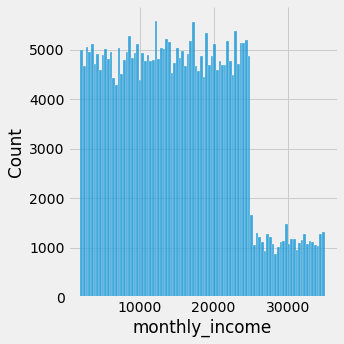

In [15]:
sns.displot(cab_data['monthly_income']);

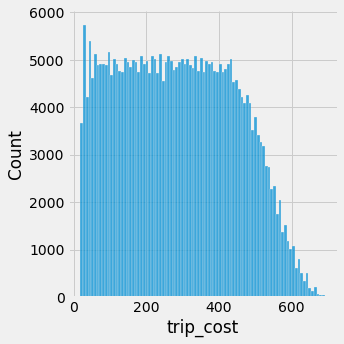

In [16]:
sns.displot(cab_data['trip_cost']);

In [17]:
# Remove outliers above count of 5000
#cab_data_trimmed = cab_data[cab_data['trip_cost'] > 100] and cab_data[cab_data['trip_cost'] < 600]


In [18]:
# Percentage of monthly income on cost of trip
percentage_monthly_income = cab_data['trip_cost'] / cab_data['monthly_income']

In [19]:
cab_data

,travel_date,transact_id,company,city,km_travelled,price_charged,trip_cost,payment_mode,gender,age,monthly_income,price_inc_05,price_diff,new_price_charged,price_inc_10,profit,daily_income
0,2016-02-06,10000011,Pink Cab,ATLANTA GA,30.45,370.95,313.6350,Card,Male,28,10813,389.4975,18.5475,389.4975,408.045,57.3150,540.65
1,2018-08-19,10351127,Yellow Cab,ATLANTA GA,26.19,598.70,317.4228,Cash,Male,28,10813,628.6350,29.9350,628.6350,658.570,281.2772,540.65
2,2018-12-22,10412921,Yellow Cab,ATLANTA GA,42.55,792.05,597.4020,Card,Male,28,10813,831.6525,39.6025,831.6525,871.255,194.6480,540.65
3,2016-02-04,10000012,Pink Cab,ATLANTA GA,28.62,358.52,334.8540,Card,Male,27,9237,376.4460,17.9260,376.4460,394.372,23.6660,461.85
4,2018-05-20,10320494,Yellow Cab,ATLANTA GA,36.38,721.10,467.1192,Card,Male,27,9237,757.1550,36.0550,757.1550,793.210,253.9808,461.85
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
344948,2018-02-05,10439790,Yellow Cab,SEATTLE WA,16.66,261.18,213.9144,Card,Female,42,19417,274.2390,13.0590,274.2390,287.298,47.2656,970.85
344949,2018-02-01,10439799,Yellow Cab,SILICON VALLEY,13.72,277.97,172.8720,Cash,Male,33,18713,291.8685,13.8985,291.8685,305.767,105.0980,935.65
344950,2018-02-02,10439838,Yellow Cab,TUCSON AZ,19.00,303.77,232.5600,Card,Male,38,3960,318.9585,15.1885,318.9585,334.147,71.2100,198.00
344951,2018-02-04,10439840,Yellow Cab,TUCSON AZ,5.60,92.42,70.5600,Cash,Male,23,19454,97.0410,4.6210,97.0410,101.662,21.8600,972.70


In [22]:
model = LinearRegression()
#cab_data = cab_data.drop('travel_date', axis=1)
features = cab_data[['trip_cost']]
X_train = features.iloc[:int(len(features)*0.8)]
X_val = features.iloc[int(len(features)*0.8):int(len(features)*0.9)]   
X_test = features.iloc[int(len(features)*0.9):]
y_train = features.iloc[:int(len(features)*0.8)]
y_val = features.iloc[int(len(features)*0.8):int(len(features)*0.9)]
y_test = percentage_monthly_income.iloc[int(len(features)*0.9):]
print(f'Linear Regression, dependent on: {features}')

Linear Regression, dependent on:         trip_cost
0        313.6350
1        317.4228
2        597.4020
3        334.8540
4        467.1192
...           ...
344948   213.9144
344949   172.8720
344950   232.5600
344951    70.5600
344952   180.3480

[344953 rows x 1 columns]


In [ ]:
#import statsmodels.api as sm
#model = sm.OLS(percentage_monthly_income, sm.add_constant(cab_data['trip_cost'])).fit()
#model.summary()

In [25]:
import category_encoders as ce
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

lr = make_pipeline(  
    LinearRegression()
)

lr.fit(X_train, y_train)
print('Linear Regression R^2', lr.score(X_val, y_val))

Linear Regression R^2 1.0


### Likely overfitting from leakage

In [26]:
coefficients = lr.named_steps['linearregression'].coef_
pd.Series(coefficients, features)

ValueError: Index data must be 1-dimensional

In [ ]:
from sklearn.metrics import r2_score
from xgboost import XGBRegressor

gb = make_pipeline(
    ce.OrdinalEncoder(), 
    XGBRegressor(n_estimators=100, objective='reg:squarederror', n_jobs=1)
)

gb.fit(X_train, y_train)
y_pred = gb.predict(X_val)
print('Gradient Boosting R^2', r2_score(y_val, y_pred))

In [ ]:
# Get a scatterplot of the predictions vs actual values
fig = go.Figure()
fig.add_trace(go.Scatter(x=y_val, y=y_pred, mode='markers', name='predictions'))
fig.add_trace(go.Scatter(x=y_val, y=y_val, mode='markers', name='actual'))
fig.update_layout(title='Gradient Boosting Predictions vs Actual', xaxis_title='Actual', yaxis_title='Predicted')
fig.plot(fig)



In [ ]:
import plotly.express as px

px.scatter(
    X_train,
    y_train,
    x='monthly_income',
    y='trip_cost',
    color='price_charged'
    title='Gradient Boosting Predictions vs Actual',    
    xaxis_title='Actual',
    yaxis_title='Predicted'

)

In [ ]:
# Convert string to datetime
X_train['travel_date'] = pd.to_datetime(X_train['travel_date'], infer_datetime_format=True)

In [ ]:
#pip install pdpbox

In [ ]:
#pip install --upgrade pip

In [ ]:
#from pdpbox import pdp
#pdp = pdp_interact.pivot_table(
#    values='preds', 
#    columns=features[0], 
#    index=features[1]
#)[::-1]

In [ ]:
# Predicted values
y_pred

## Neural Networks

Let's see what validation we will get by using a neural network.

In [ ]:
train, test = train_test_split(cab_data, test_size=0.2, stratify=cab_data['season'])
train, val = train_test_split(cab_data, test_size=0.2, stratify=cab_data['season'])


# Create a function to create a model and train it
def create_model(train, val):
    model = tf.keras.Sequential([
        tf.keras.layers.Dense(10, activation='relu'),
        tf.keras.layers.Dense(10, activation='relu'),
        tf.keras.layers.Dense(1)
    ])

    model.compile(loss='mse', optimizer='adam')

    history = model.fit(train[['total_price_charged', 
                                'price_charged']], 
                                train['profit'], 
                                epochs=40, 
                                validation_data=(val[['total_price_charged', 'price_charged']], 
                                val['profit']))
    return model, history

model, history = create_model(train, val)

In [ ]:
# Create a function to plot the model's performance
def plot_model_performance(history):
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend(['Train', 'Validation'])
    
plot_model_performance(history)
plt.savefig('model_loss.png')

In [ ]:
# Permutation importance for features used in XGBR model
perm = PermutationImportance(history,random_state=42).fit(X_val,y_val)
eli5.show_weights(perm, feature_names = samp.columns.tolist())

### Time Series Analysis

We can use statsmodels to perform time series analysis and get a general idea of the data over time on univariate data.

In [ ]:
# Create a subset of cab_data with parsed travel_date and trip_cost
cab_data_subset = cab_data[['travel_date', 'trip_cost']]

# Index the cab_data_subset by travel_date
cab_data_subset.set_index('travel_date', inplace=True)

In [ ]:
# Create an univariate time series dataset indexed by the travel date
ts_data = pd.DataFrame(cab_data['trip_cost'], index=cab_data['travel_date'])

# Create a function to determine the autocorrelation of the time series
def autocorrelation(ts_data):
    """
    Method:
        Create a function to determine the autocorrelation of the time series
    """
    # Calculate the autocorrelation of the time series
    acf_data = ts.acf(ts_data)
    
    # Plot the autocorrelation of the time series
    plt.figure(figsize=(10,6))
    plt.plot(acf_data)
    plt.xlabel('Lag')
    plt.ylabel('Autocorrelation')
    plt.title('Autocorrelation of Trip Cost')
    plt.show()
    return


autocorrelation(ts_data)

In [ ]:
# Create a function to determine the partial autocorrelation of the time series
def partial_autocorrelation(ts_data):
    """
    Method:
        Create a function to determine the partial autocorrelation of the time series
    """
    # Calculate the partial autocorrelation of the time series
    pacf_data = ts.pacf(ts_data)
    # Plot the partial autocorrelation of the time series
    plt.figure(figsize=(10,6))
    plt.plot(pacf_data)
    plt.xlabel('Lag')
    plt.ylabel('Partial Autocorrelation')
    plt.title('Partial Autocorrelation of Trip Cost')
    plt.show()
    return

In [ ]:
# Create a function to determine the ADF test of the time series
def adf_test(ts_data):
    """
    Method:
        Create a function to determine the ADF test of the time series
    """
    # Calculate the ADF test of the time series
    adf_data = adfuller(ts_data)
    # Plot the ADF test of the time series
    plt.figure(figsize=(10,6))
    plt.plot(adf_data)
    plt.xlabel('Lag')
    plt.ylabel('ADF Test')
    plt.title('ADF Test of Trip Cost')
    plt.show()
    return
    

In [ ]:
# Create a function to determine the ARIMA model of the time series
def arima_model(ts_data):
    """
    Method:
        Create a function to determine the ARIMA model of the time series
    """
    # Calculate the ARIMA model of the time series
    arima_data = ARIMA(ts_data, order=(1,1,1)).fit()
    # Plot the ARIMA model of the time series
    plt.figure(figsize=(10,6))
    plt.plot(arima_data.fittedvalues)
    plt.xlabel('Date')
    plt.ylabel('Trip Cost')
    plt.title('ARIMA Model of Trip Cost')
    print(arima_data.summary())
    plt.show()
    return